Вариант 19: 
*Hierarchical text classification*

**исходные**: text

**прогнозные**: cat1

url: https://www.kaggle.com/kashnitsky/hierarchical-text-classification

### Необходимые библиотеки

In [ ]:
import numpy as np
import pandas as pd
import random

import collections
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import string
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.vocab import GloVe

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Загрузить набор данных (Hierarchical text classification)

predict: text

feature: cat1

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/datasets/train_40k.csv')
data.head(3)

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3
0,B000E46LYG,Golden Valley Natural Buffalo Jerky,A3MQDNGHDJU4MK,0/0,3.0,-1,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,B000GRA6N8,Westing Game,unknown,0/0,5.0,860630400,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,B000GRA6N8,Westing Game,unknown,0/0,5.0,883008000,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown


In [ ]:
data = data[['Text','Cat1']]
data.head(3)

,Text,Cat1
0,The description and photo on this product need...,grocery gourmet food
1,This was a great book!!!! It is well thought t...,toys games
2,"I am a first year teacher, teaching 5th grade....",toys games


### Exploratory Data Analysis (EDA) on Text Data

**Analyzing text statistics**


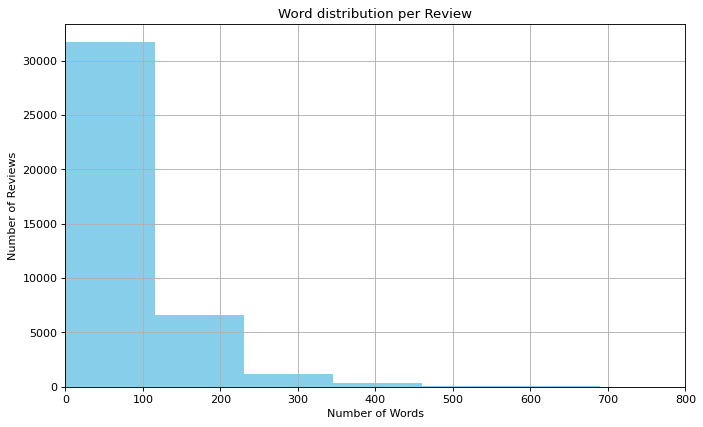

The histograms shows that reviews range from 0 to almost 700 words. Mostly, it is between 0 and 100 words per review.


In [ ]:
# word-analysis

figure(figsize=(10, 6), dpi=80)
data.Text.str.split().apply(lambda x: len(x)).hist(color = 'skyblue')
plt.xlim([0, 800])
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.title("Word distribution per Review")
plt.show()
print('The histograms shows that reviews range from 0 to almost 700 words. Mostly, it is between 0 and 100 words per review.')

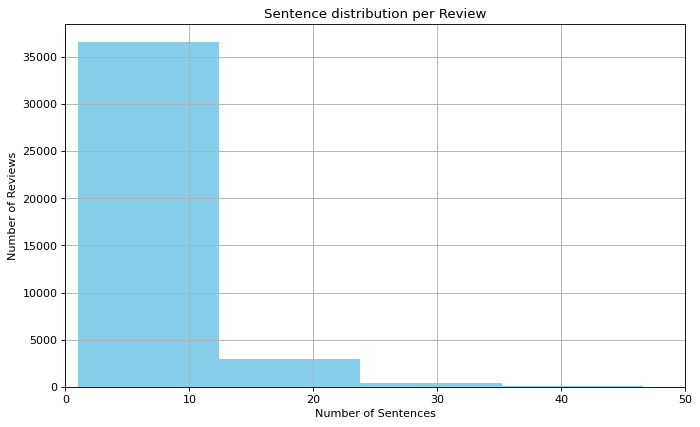

The histograms shows that reviews range from 0 to almost 50 sentences. Mostly, it is between 0 and 10 words per review.


In [ ]:
# next level: sentence-analysis

figure(figsize=(10, 6), dpi = 80)
data.Text.str.split('.').apply(lambda x: len(x)).hist(color = 'skyblue')
plt.xlim([0, 50])
plt.xlabel("Number of Sentences")
plt.ylabel("Number of Reviews")
plt.title("Sentence distribution per Review")
plt.show()
print('The histograms shows that reviews range from 0 to almost 50 sentences. Mostly, it is between 0 and 10 sentences per review.')

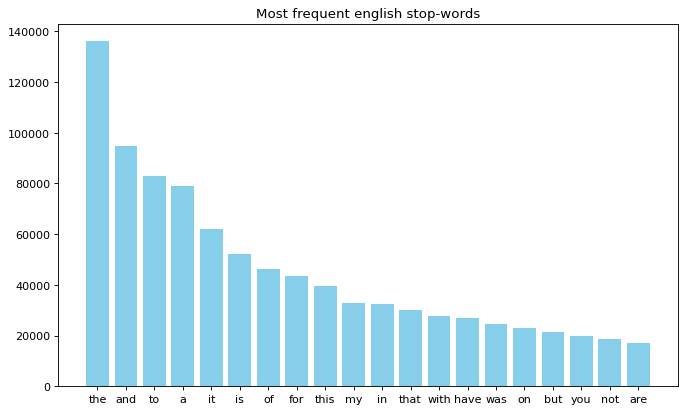

In [ ]:
# stop-word distribution
stop = set(stopwords.words('english'))
corpus = []
temp = data.Text.str.split().values.tolist()

corpus = [word for i in temp for word in i]
dict_sw = defaultdict(int)
for word in corpus:
    if word in stop:
        dict_sw[word] += 1


stop_words = sorted(dict_sw.items(), key = lambda x: x[1], reverse = True) # sorted by frequency
top_sw = stop_words[:20] # top 20


word = []
frequency = []
for i in range(len(top_sw)):
  word.append(top_sw[i][0])
  frequency.append(top_sw[i][1])

figure(figsize=(10, 6), dpi=80)
plt.bar(word, frequency, color='skyblue')
plt.title("Most frequent english stop-words")
plt.show()


**Lets look at toys games as an example:**


Text(0.5, 1.0, 'Most frequent words in toys category')

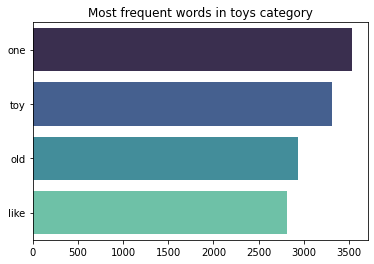

In [ ]:
c = data.loc[data['Cat1'] == 'toys games']
c_corpus = []
temp = c.Text.str.lower().str.split().values.tolist()
c_corpus = [word for i in temp for word in i]

c_counter = collections.Counter(c_corpus)
most_freq = c_counter.most_common()

x, y = [], []
for word, count in most_freq[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x = y, y = x, palette = 'mako').set_title('Most frequent words in toys category')

### Exploratory Data Analysis (EDA) on Target Data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

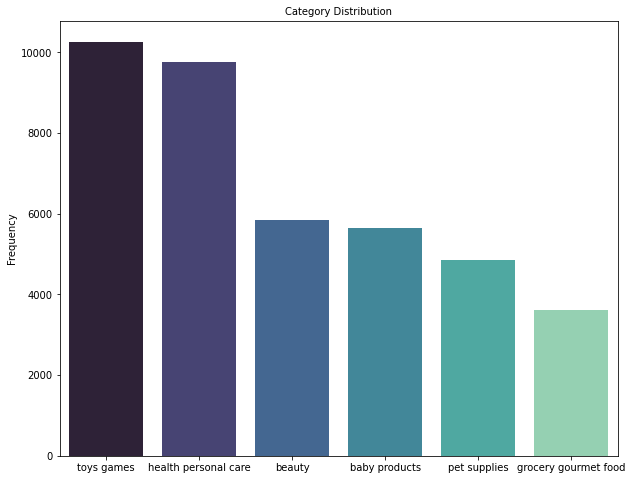

In [ ]:
x_cat = data.Cat1.value_counts()
y_cat = x_cat.sort_index()

plt.figure(figsize=(10,8))
sns.barplot(x_cat.index, x_cat.values, palette = 'mako')
plt.title("Category Distribution", fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.yticks(fontsize=10)

plt.xticks(fontsize=10)

### Text preprocessing

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  #numbers
    text = re.sub(' +', ' ', text)
    text = re.sub('@[^\s]+', ' ', text)
    text = re.sub('[^a-zA-z]+', ' ', text)
    
    return text.strip() #white space 

data_prep = [preprocess_text(t) for t in data.Text]

# stop-words 
stop_words = set(stopwords.words('english'))
#ps = PorterStemmer()

def nltk_preprocess_text(text):
    tokens = word_tokenize(text)
    filtered_tokens = []
    for token in tokens:
      if token not in stop_words:
        filtered_tokens.append(token)
          #filtered_tokens.append(ps.stem(token))
    text = " ".join(filtered_tokens)
    return text

data_prep_ = [nltk_preprocess_text(t) for t in data_prep]

In [ ]:
d = {'clean_text': data_prep_, 'cat': data.Cat1.values}
df = pd.DataFrame(d)
df.head(5)

,clean_text,cat
0,description photo product needs changed indica...,grocery gourmet food
1,great book well thought easily imagine events ...,toys games
2,first year teacher teaching th grade special r...,toys games
3,got book bookfair school looking something sum...,toys games
4,hi martine redman created puzzle briarpatch us...,toys games


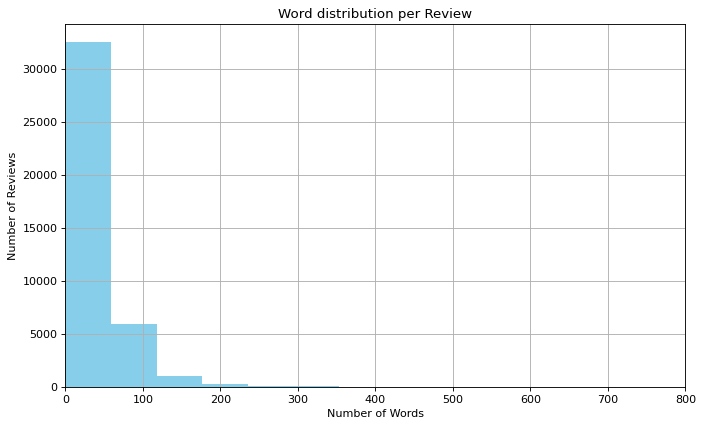

In [ ]:
figure(figsize=(10, 6), dpi=80)
df.clean_text.str.split().apply(lambda x: len(x)).hist(color = 'skyblue')
plt.xlim([0, 800])
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.title("Word distribution per Review")
plt.show()

In [ ]:
false_count = [i for i, x in enumerate(df.clean_text.str.split().apply(lambda x: len(x) > 100)) if x]
df = df.drop(false_count)
df = df.reset_index(drop=True)

### LabelEncoder + undersampling который не помог

In [ ]:
lst = df.cat.unique()
le = LabelEncoder()
le.fit(lst)
for i in range(len(df)):
  df.cat[i] = le.transform([df.cat[i]]).item()

### Train test split

In [ ]:
x = df.clean_text.values
y = df.cat.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 42)
print("Training Data: ", len(x_train))
print("Testing Data: ", len(x_test))

Training Data:  30296
Testing Data:  7574


### Functions

In [ ]:
def conf_matrix(model, r_dataloader_test, nb_classes, is_gru = False):
   correct1, total1 = 0, 0
   confusion_matrix = torch.zeros(nb_classes, nb_classes)
   with torch.no_grad():
      for i, (inputs, classes) in enumerate(r_dataloader_test):
          inputs = inputs
          classes = classes

          outputs = model(inputs.long())

          _, preds = torch.max(outputs, 1)
          total1 += classes.shape[0]
          correct1 += int((preds == classes).sum())
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1

   print(f'Test Accuracy: {correct1 / total1}')
   cm = confusion_matrix
   plt.figure(figsize=(12, 6))

   tick = le.classes_
   ax = sns.heatmap(cm, annot=True, fmt="f", linewidths=.5, cmap="YlGnBu", xticklabels = tick, yticklabels = tick)
   plt.xlabel("actual values") 
   plt.ylabel("predicted values") 

   return cm

In [ ]:
def train_model(model, dataloader, loss, optimizer, n_epochs, is_gru = False):
    losses = []
    for epoch in range(n_epochs):
      for x_batch, y_batch in dataloader:
        
        x_batch = x_batch.long()
        y_batch = y_batch.long()

        out = model(x_batch)

        # loss
        batch_loss = loss(out, y_batch)

        # backward
        batch_loss.backward()

        # optimization
        curr_loss = []
        optimizer.step()
        optimizer.zero_grad()
        curr_loss.append(batch_loss.item())
      losses.append(np.mean(curr_loss))

      print(f"Epoch: {epoch}, loss: {losses[-1]}")

    return losses



### Glove + loaders

In [ ]:
# stoi – A collections.defaultdict instance mapping token strings to numerical identifiers.
# itos – A list of token strings indexed by their numerical identifiers.

glove = GloVe(name = '6B', dim = 100, unk_init = torch.Tensor.normal_)

glove.stoi['<PAD>'] = len(glove.stoi)
glove.itos.append('<PAD>')

glove.stoi['<UNK>'] = len(glove.stoi)
glove.itos.append('<UNK>')

glove.vectors = torch.cat([glove.vectors, torch.zeros((2, 100))])

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, X, y, vocab):
        self.X = X 
        self.y = y 
        self.vocab = vocab 
        self.maxlen = 200

    def vectorize(self, review): 
        review_t = torch.zeros(self.maxlen).long()
        
        for i, word in enumerate(word_tokenize(review)): 
            if i <= self.maxlen:
              try:
                review_t[i] = self.vocab.stoi[word]
              except:
                review_t[i] = self.vocab.stoi['<UNK>']
        return review_t

    def __getitem__(self, idx):
        return self.vectorize(self.X[idx]), torch.tensor(self.y[idx])

    def __len__(self):
        return len(self.X)

In [ ]:
# basic params
embed_dim = 100
batch_size = 128 
n_epochs = 5

review_train = ReviewDataset(x_train, y_train, glove)
review_test = ReviewDataset(x_test, y_test, glove)

r_dataloader_train = DataLoader(review_train, batch_size = batch_size)
r_dataloader_test = DataLoader(review_test, batch_size = batch_size)

max_features = len(glove)
maxlen = len(ReviewDataset(x_train, y_train, glove)[1][0])

### CNN 

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, *args):
        super().__init__()

        n_classes = len(le.classes_)
        self.maxlen = maxlen
        self.embedding = nn.Embedding(max_features, embed_dim)
        self.embedding = self.embedding.from_pretrained(glove.vectors)
        self.dropout = nn.Dropout(0.1)

        self.conv1 = nn.Sequential(
            nn.Conv1d(embed_dim, 32, 5),    
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),                                           
        )


        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(98*32, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, n_classes),
        )
                                          
    def forward(self, x): 
        #print(x.shape)
        out = self.embedding(x)
        #print(out.shape) 
        out = out.permute(0,2,1)
        #print(out.shape) 
        out = self.conv1(out)
        #print(out.shape) 
        out = self.dropout(out)
        # out = self.conv2(out)
        # out = self.dropout(out)
        out = self.layer(out)
        return out

Epoch: 0, loss: 0.5442927479743958
Epoch: 1, loss: 0.3872726559638977
Epoch: 2, loss: 0.3137229084968567
Epoch: 3, loss: 0.2526610493659973
Epoch: 4, loss: 0.23148204386234283
Epoch: 5, loss: 0.21657371520996094
Epoch: 6, loss: 0.20173530280590057
Epoch: 7, loss: 0.18684491515159607
Epoch: 8, loss: 0.15859271585941315
Epoch: 9, loss: 0.22197981178760529


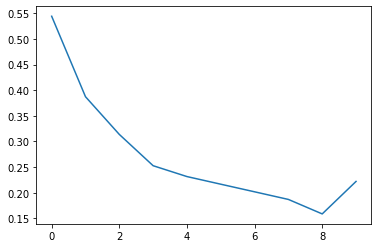

In [ ]:
CNN_pre = CNN()

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN_pre.parameters(), lr = 0.001) 
train_loss = train_model(CNN_pre, r_dataloader_train, loss, optimizer, n_epochs = 10, is_gru = False)

plt.plot(train_loss)

Test Accuracy: 0.7421992954202316
tensor([0.7111, 0.7180, 0.7083, 0.6679, 0.8123, 0.8181])
['baby products' 'beauty' 'grocery gourmet food' 'health personal care'
 'pet supplies' 'toys games']


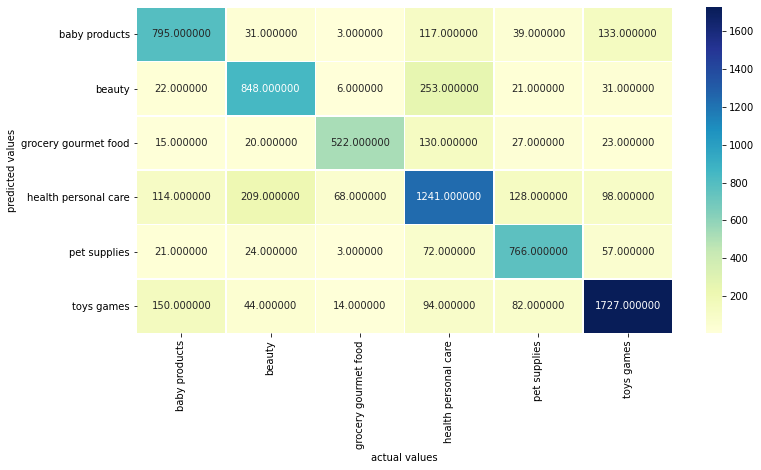

In [ ]:
nb_classes = len(le.classes_)
cm = conf_matrix(CNN_pre, r_dataloader_test, nb_classes, is_gru = False)
print(cm.diag()/cm.sum(1)) #per-class accuracy
print(le.classes_)

### GRU


In [ ]:
class GRU(nn.Module):
    def __init__(self, *args):
        super().__init__()
        
        hid = 64
        n_classes = len(le.classes_)
        self.maxlen = maxlen
        self.embedding = nn.Embedding(max_features, embed_dim)
        self.embedding = self.embedding.from_pretrained(glove.vectors)
        
        self.gru = nn.GRU(embed_dim, hid, num_layers = 1, batch_first = True) 
        
        self.layer1 = nn.Sequential(
            nn.Linear(hid, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, n_classes),

        )

    def forward(self, x):
        out = self.embedding(x)
        out, h = self.gru(out)
        out = self.layer1(out[:,-1]) 

        return out, h


Epoch: 0, loss: 0.42791664600372314
Epoch: 1, loss: 0.28003451228141785
Epoch: 2, loss: 0.11925020068883896
Epoch: 3, loss: 0.19955149292945862
Epoch: 4, loss: 0.14495758712291718
Epoch: 5, loss: 0.0846480056643486
Epoch: 6, loss: 0.07908818870782852
Epoch: 7, loss: 0.10106189548969269
Epoch: 8, loss: 0.09314945340156555
Epoch: 9, loss: 0.07374335825443268


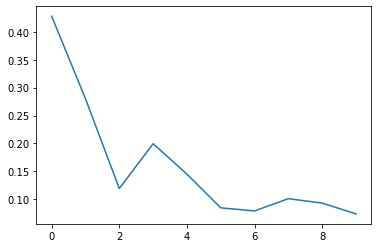

In [ ]:
GRU_pre = GRU()

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(GRU_pre.parameters(), lr = 0.01) 
train_loss = train_model(GRU_pre, r_dataloader_train, loss, optimizer, n_epochs = 10, is_gru = True)
plt.plot(train_loss)


Test Accuracy: 0.8068696527428284
tensor([0.7612, 0.7519, 0.7232, 0.8283, 0.8600, 0.8484])
['baby products' 'beauty' 'grocery gourmet food' 'health personal care'
 'pet supplies' 'toys games']


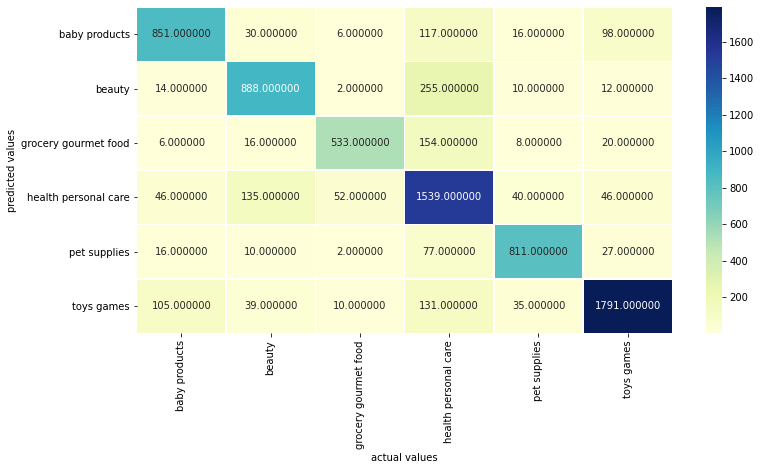

In [ ]:
nb_classes = len(le.classes_)
cm = conf_matrix(GRU_pre, r_dataloader_test, nb_classes, is_gru = True)
print(cm.diag()/cm.sum(1)) #per-class accuracy
print(le.classes_)